# SVM for classification

### Importing Libraries for running the code and plotting the results

In [121]:
import os
import numpy as np
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt
np.random.seed(102)

### Importing sklearn tools and methods to proof the algorithm is working correctly

In [122]:
from sklearn.svm import SVC 
from sklearn.utils import resample 
from sklearn.decomposition import PCA 
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, plot_confusion_matrix

## Dataset Preparation

In [152]:
# load datasets function
def load_data(data_file_name):
    data_dir = "..\..\..\data\data_classification"
    data_path = os.path.join(data_dir, data_file_name)
    df = pd.read_csv(data_path, header=1)
    print(df)
    data_X = df.iloc[:,:-1]
    data_y = df.iloc[:,-1]
    scaler_X = StandardScaler()
    data_X = scaler_X.fit_transform(data_X)
    data_y = pd.Categorical(data_y).codes.reshape(-1)
    return data_X, data_y

## Importing the data

In [153]:

def main():

    # read dataset from csv file
    data_name = "messidor_classification"
    data_X, data_y = load_data("{}.csv".format(data_name))

    # Train and test set
    # kf = KFold(n_splits=10)
    # res_list = []
    # for train_index, test_index in kf.split(data_X):
    #     train_X, train_y = data_X[train_index,:], data_y[train_index]
    #     test_X, test_y = data_X[test_index,:], data_y[test_index]
    return data_X, data_y



In [167]:
from numpy import int8


data_dir = "..\..\..\data\data_classification"
data_path = os.path.join(data_dir, "messidor_classification.csv")
df = pd.read_csv(data_path, header=0)
df['Class'] = df['Class'].str.split("b'").str[1]
df['Class'] = df['Class'].str.split("'").str[0]
df['Class'] = df['Class'].astype(int8)
print(df['Class'])

0       0
1       0
2       1
3       0
4       1
       ..
1146    0
1147    0
1148    0
1149    1
1150    0
Name: Class, Length: 1151, dtype: int8


## Data Preprocessing

In order to improve our performance, we want to make sure that the data we are dealing with is good. This means, there is no missing data, we are aware of the data types, and we fix possible mistakes. 

In [142]:
x, y = main()
# dfx = np.array(dfx, dtype=np.float32)
# dfy = np.array(dfy, dtype=np.int64)
dfx = pd.DataFrame(x) 
dfy = pd.DataFrame(y) 

In [143]:
# dfx.dtypes
dfx.rename({0 : 'col_0',
            1 : 'col_1',
            2 : 'col_2',
            3 : 'col_3',
            4 : 'col_4',
            5 : 'col_5',
            6 : 'col_6',
            7 : 'col_7',
            8 : 'col_8',
            9 : 'col_9',
            10: 'col_10',
            11: 'col_11',
            12: 'col_12',
            13: 'col_13',
            14: 'col_14',
            15: 'col_15',
            16: 'col_16',
            17: 'col_17',
            18: 'col_18'}, axis='columns', inplace=True)
dfy.rename({0:'y'}, axis='columns', inplace=True) 
dfy.head()


,y
0,1
1,1
2,1
3,1
4,1


## Implementation of SVM

We choose the Gaussian kernel (RBF kernel) for SVM. For any $x_i, x_j \in\mathbb{R}^d$, we define
$$
\kappa(x_i, x_j) = \exp \bigl( - \|x_i - x_j\|^2 / (2 \sigma^2) \bigr)
$$ 
where $\sigma > 0$ is the width of the Gaussian kernel.

In [127]:
class SVM():
    '''
    This is a class for support vector machine.
    
    The class contains the hyper-parameters such as $C$ and the kernel bandwidth $\sigma$. It also contains 
    the alpha vector, the tolerance for prediction error and the maximum number of iteration.
    
    It contains the functions for calculating the kernel matrix, fitting the model to estimate alpha and b 
    with SMO algorithm, making predictions and other fundamental functions.
    
    Attributes:
        C (positive number)         - the hyperparameter for SVM algorithm
        sigma (positive number)     - the kernel bandwidth $\sigma$ of Gaussian kernel 
        toler (positive number)     - the threshold value of prediction error. If the prediction error of 
                                      a sample is larger than this value, the corresponding alpha_i will be 
                                      probably updated.
        maxIter (positive integer)  - the maximum number of iteration to search a pair of alpha's to update
        alphas (vector, num_samples)- the alpha vector in the dual problem 
        b (number)                  - the bias b
    '''
    
    def __init__(self, C = 1, sigma = 1, toler = 0.01, maxIter = 100):
        self.C = C
        self.sigma = sigma
        self.toler = toler
        self.maxIter = maxIter
        self.alphas = 0
        self.b = 0
        
    def rbfkernel(self, X, Y):
        '''
        Calculate the kernel matrix whose (i,j)-th entry is $k(X[i,:], Y[j,:])$.
        '''
        m = X.shape[0]
        n = Y.shape[0]
        K = np.zeros(shape=(m, n))
        for i in range(m):
            for j in range(n):
                K[i, j] = np.sum((X[i,:] - Y[j,:])**2)
        K = np.exp(-K / (2 * self.sigma**2))
        return K

    def selectJrand(self, i, m):
        '''
        Randomly choose an index $j\neq i$ from 0 to m-1
        '''
        j = i 
        while (j == i):
            j = int(np.random.uniform(0, m))
        return j


    def clipAlpha(self, aj, H, L):
        '''
        Clip the vale aj by the lower bound L and upper bound H
        '''
        if aj > H:
            aj = H
        if L > aj:
            aj = L
        return aj


    def fit(self, X_train, y_train):
        '''
        estimate the alphas vector and bias in the SVM model
        
        Args: 
            X_train (matrix, num_train*num_features): features of training samples
            y_train (vector, num_train): label of training samples, each label is either -1 or 1
            
        Returns:
            self.b (a number)                 : the bias
            self.alphas (vector, num_features): the alpha vector 
        ''' 
        K_train = self.rbfkernel(X_train, X_train)
        self.X_train = X_train
        self.y_train = y_train
        m = K_train.shape[0]
        self.alphas = np.zeros((m, ))
        num_iter = 0
        while (num_iter < self.maxIter):
            alphaPairsChanged = 0
            # optimize for each data vector (with kernel trick)
            for i in range(m):   
                fXi = (self.alphas * y_train) @ K_train[i, :] + self.b
                # if checks if an example violates KKT conditions
                Ei = fXi - y_train[i]
                if ((y_train[i] * Ei < -self.toler) and (self.alphas[i] < self.C)) \
                       or ((y_train[i] * Ei > self.toler) and (self.alphas[i] > 0)):
                    j = self.selectJrand(i, m)
                    fXj = (self.alphas * y_train) @ K_train[j, :] + self.b
                    Ej = fXj - y_train[j]
                    alphaJold = self.alphas[j].copy()
                    alphaIold = self.alphas[i].copy()
                    if (y_train[j] != y_train[i]):
                        L = max(0, self.alphas[i] - self.alphas[j])
                        H = min(self.C, self.C + self.alphas[i] - self.alphas[j])
                    else:
                        L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        H = min(self.C, self.alphas[i] + self.alphas[j])
                    if L == H:
                        continue
                    eta = 2.0 * K_train[j, i] - K_train[j, j] - K_train[i, i]
                    if eta >= 0:
                        continue
                    self.alphas[i] += y_train[i] * (Ei - Ej) / eta
                    self.alphas[i] = self.clipAlpha(self.alphas[i], H, L)
                    if (abs(self.alphas[i] - alphaIold) < 0.00001):
                        continue
                    # update i by the same amount as j, the direction depends on y[i] and y[j]
                    self.alphas[j] += y_train[i] * y_train[j] * (alphaIold - self.alphas[i])
                    # update self.b
                    b1 = self.b - Ej - y_train[j] * (self.alphas[j] - alphaJold) * K_train[
                        j, j] - y_train[i] * (self.alphas[i] - alphaIold) * K_train[j, i]
                    b2 = self.b - Ei - y_train[j] * (self.alphas[j] - alphaJold) * K_train[
                        j, i] - y_train[i] * (self.alphas[i] - alphaIold) * K_train[i, i]
                    if (0 < self.alphas[j]) and (self.C > self.alphas[j]): self.b = b1
                    elif (0 < self.alphas[i]) and (self.C > self.alphas[i]): self.b = b2
                    else: self.b = (b1 + b2) / 2.0
                    alphaPairsChanged += 1
            if (alphaPairsChanged == 0): num_iter += 1
            else: num_iter = 0
        return self.b, self.alphas


    def predict(self,X_test):
        '''
        predict the label of test samples
        Args:
            X_test(matrix, num_test*num_features): features of test samples
        Returns:
            y_hat(vector, num_test): the predicted label of test samples, each label is either -1 or 1
        '''
        K_test = self.rbfkernel(self.X_train, X_test)
        f = K_test.T @ (self.alphas * self.y_train) + self.b
        y_hat = np.sign(f)
        return y_hat

## Run SVM on the dataset

In [128]:
def t_t():
    # Randomly assingning a train and test set
    train_X, test_X, train_y, test_y = train_test_split(main()[0], main()[1], test_size=0.33, random_state=100)
    return train_X, test_X, train_y, test_y

In [129]:
clf_svm = SVC(random_state=42)
clf_svm.fit(t_t()[0], t_t()[2])

SVC(random_state=42)

c:\Users\josep\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


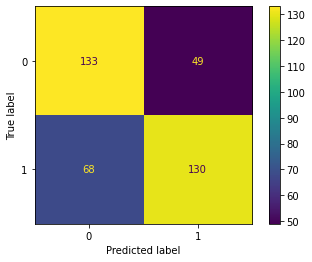

In [130]:
plot_confusion_matrix(clf_svm,t_t()[1],  t_t()[3], values_format='d')

In [131]:
param_grid = [{'C':[0.5, 1, 10, 100], 'gamma': ['scale', 1, 0.1, 0.01, 0.001], 'kernel': ['rbf'] }]

In [132]:
from sklearn.model_selection import GridSearchCV

optimal_params = GridSearchCV(SVC(),
                             param_grid,
                             cv = 5,
                             scoring = 'accuracy' )

optimal_params.fit(t_t()[0], t_t()[2])
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [136]:
clf_svm = SVC(random_state=42, C = 100, gamma=0.01)
clf_svm.fit(t_t()[0], t_t()[2])

SVC(C=100, gamma=0.01, random_state=42)

c:\Users\josep\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


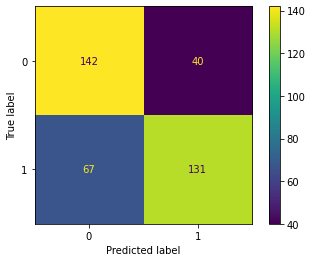

In [137]:
plot_confusion_matrix(clf_svm,t_t()[1],  t_t()[3], values_format='d')

In [ ]:
pca = PCA()

In [133]:
def run():
    # running the model and getting the accuracy
    model_SVM = SVM(C = 100, sigma = 2, toler=0.001, maxIter=40)
    b, alphas = model_SVM.fit(t_t()[0], t_t()[2])
    y_test_hat = model_SVM.predict(t_t()[1])
    accuracy = np.mean(y_test_hat == t_t()[3])
    print("The accuracy of SVM is:", accuracy)

In [120]:
run()

The accuracy of SVM is: 0.010526315789473684


In [134]:
# def loadDataSet(dataset_path):
#     data = pd.read_table(dataset_path, header=None)
#     data_X, data_y = data.iloc[:, :-1], data.iloc[:, -1]
#     data_X = np.array(data_X, dtype=np.float32)
#     data_y = np.array(data_y, dtype=np.int64)
#     data_y[data_y == 0] = -1
#     return data_X, data_y

In [135]:
# # read the data
# X_train, y_train = loadDataSet("horseColicTraining.txt") 
# X_test, y_test = loadDataSet("horseColicTest.txt")
# # normalize
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)